# Mixture of Gaussians

In this note, we will show how to estimate the mixture of diagonal Gaussians using Polymom

This block contains some $\LaTeX$ macros.
$\newcommand{\E}{\mathbb{E}}$
$\renewcommand{\Re}{\mathbb{R}}$
$\newcommand{\oft}[1]{{^{(#1)}}}$
$\newcommand{\oftt}[2]{{^{(#1)#2}}}$

In [1]:
# just importing stuff
import util
from util import *
import numpy as np
import models
import mompy as mp
import cvxopt
cvxopt.solvers.options['show_progress'] = False
np.set_printoptions(precision=3, suppress=True)
from IPython.display import display, Markdown, Math
from operator import mul
import sympy as sp
sp.init_printing()

## Noiseless Demo

Let's first consider the noiseless case.

Let $\xi_1, ..., \xi_K \in \Re^D$ be the set of means. Let $c_1, ..., c_K \in \Re^D$ be the set of diagonal covariances.

In [2]:
k = 2
d = 2
degobs = 4
degmm = 3

sc.random.seed(102)
gm = models.GaussianMixtureModel.generate(k, d, means='hypercubenoise', cov='diagonal')
gm.polymom_init_symbols(spherical = False)
monos = gm.polymom_monos(degmm)
constraints = gm.polymom_all_constraints(degobs)
xis = gm.sym_means
covs = gm.sym_covs
sym_all = xis + covs
print 'The true polynomial constraints are:'
display(constraints)

The true polynomial constraints are:


With this machinery, we can compute the moment polynomials required.

In [3]:
MM = mp.MomentMatrix(degmm, sym_all, morder='grevlex', monos=monos)
solsdp = mp.solvers.solve_basic_constraints(MM, constraints, 1e-8);

In [4]:
sol_lasserre = mp.extractors.extract_solutions_lasserre(MM, solsdp['x'], Kmax = k)

print 'the true variances'
print (gm.sigmas)
print 'recovered parameters'
print sol_lasserre[covs[0]]
print sol_lasserre[covs[1]]

the true variances
[[[ 0.679  0.   ]
  [ 0.     0.746]]

 [[ 0.745  0.   ]
  [ 0.     0.947]]]
recovered parameters
[ 0.745  0.679]
[ 0.947  0.746]


## Now take samples and test the following methods
- M_polymom: polymom
- M_EM: the sklearn implementation of EM
- M_spectral: the tensor factorization algorithm
- M_true: Permutating the true paramters for sanity check



'a 2D projection of this distribution is'

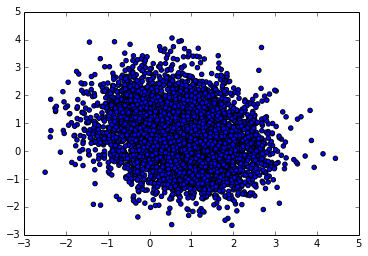

In [5]:
num_samples = 5000
X = gm.sample(num_samples)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy.linalg

# plot after a random orthogonal projection
randdir,__,__ = np.linalg.svd(np.random.randn(d,2))
Y = X.dot(randdir[:,0:2])
display("a 2D projection of this distribution is")
plt.scatter(X[:,0], X[:,1]);


## Define some estimators
all methods takes the model and sample as arguments, and returns estimated mean and optionally variances

In [6]:
# all functions in this block returns the mean and variance and take the model and samples
def M_polymom(gm, X, degmm=3, degobs=4, spherical=False):
    tol= 1e-2
    k = gm.k
    gm.polymom_init_symbols(spherical)
    monos = gm.polymom_monos(degmm)
    constraints = gm.polymom_all_constraints(degobs)
    xis = gm.sym_means
    covs = gm.sym_covs
    sym_all = xis + covs
    MM = mp.MomentMatrix(degmm, sym_all, morder='grevlex', monos=monos)
    constraints_noisy = gm.polymom_all_constraints_samples(degobs, X)
    solsdp_noisy = mp.solvers.solve_basic_constraints(MM, constraints_noisy, slack = 1e-5)
        
    sol_noisy = mp.extractors.extract_solutions_lasserre(MM, solsdp_noisy['x'], Kmax = k)
    # M should always be k by d
    Mlist = []
    Clist = []
    for dim in xis:
        Mlist.append(sol_noisy[dim])
    for dim in covs:
        Clist.append(sol_noisy[dim])
    
    M_ = sc.column_stack(Mlist)
    C_ = sc.column_stack(Clist)
    return M_,C_

# this method unfortunately does not return the variance
def M_Spectral(gm, X):
    k = gm.k
    import algos.GaussianMixturesSpectral as gms
    M_ = gms.find_means(X, k).T
    assert(M_.shape == (gm.k, gm.d))
    return M_,None

def M_EM(gm, X):
    from sklearn import mixture
    k = gm.k
    sklgmm = mixture.GMM(n_components=k, covariance_type='diag', n_init=5, n_iter = 10, thresh = 1e-2)
    sklgmm.fit(X)
    return sklgmm.means_, sklgmm.covars_

def M_true(gm, X):
    M_ = sc.random.permutation(gm.means.T)
    Clist = []
    for covmat in gm.sigmas:
        Clist += [sc.diag(covmat).tolist()]
    C_ = sc.random.permutation(sc.row_stack(Clist))
    return M_, C_

## The test routine

In [7]:
from collections import Counter

estimators = [M_EM, M_Spectral, M_polymom, M_true]
totalerror = Counter()
Mstar = gm.means.T
for i,theta_hat in enumerate(estimators):
    M_,C_ = theta_hat(gm, X)
    M_ = closest_permuted_matrix(Mstar, M_)
    print theta_hat.func_name
    display (M_)
    totalerror[theta_hat.func_name] += column_rerr( Mstar, M_ )

M_EM


array([[ 1.207,  0.016],
       [ 0.275,  1.095]])

M_Spectral


array([[ 1.206,  0.001],
       [ 0.282,  1.266]])

M_polymom


array([[ 1.192,  0.077],
       [ 0.237,  1.104]])

M_true


array([[ 1.174,  0.05 ],
       [ 0.243,  1.094]])

In [8]:
print totalerror

Counter({'M_Spectral': 0.16388230575084853, 'M_EM': 0.038823221425087102, 'M_polymom': 0.026163575505506183, 'M_true': 0.0})
